In [1]:
# add version and author info
__version__ = "1.0.0"
__author__ = "Fabrizio Berritta, Torbjørn Rasmussen"
__license__ = "PolyForm Noncommercial License 1.0.0 (https://polyformproject.org/licenses/noncommercial/1.0.0)"

"""
FREQUENCY BAYES
This experiment performs Bayesian estimation of qubit frequency using repeated Ramsey-style experiments.
The procedure involves preparing the qubit, waiting for varying idle times, and then performing state 
discrimination [1, 2]. Bayesian inference is then applied to update a probability distribution over possible 
detunings, converging toward the most likely frequency.

The data is collected across multiple repetitions and processed into an evolving probability distribution 
P(f) which are plotted for visualization, alongside single-shot measurement results from which the Bayesian
updates are derived.

A more adaptive algorithm is presented in Ref. [3], where the estimation precision scales exponentially with
the number of measurements, by optimally choosing both the idle times and the qubit drive frequency.

The analysis enables:
    - Estimation of qubit detuning and frequency drift.

Prerequisites:
    - Qubit pi/2 ("x90") pulses calibrated.
    - Qubit resonator readout calibrated with state discrimination enabled.
    - QuAM configuration and qubit state loaded.
    
References:

[1] Shulman, M. D., Harvey, S. P., Nichol et al. Suppressing qubit dephasing using real-time Hamiltonian estimation. Nature communications, 5(1), 5156 (2014). [https://doi.org/10.1038/ncomms6156]
[2] Berritta, F., Rasmussen, T., Krzywda, J. A. et al. Real-time two-axis control of a spin qubit. Nature Communications, 15(1), 1676 (2024). [https://doi.org/10.1038/s41467-024-45857-0]
[3] Berritta, F., Benestad, J., Pahl, L., Mathews, M., et al. Efficient Qubit Calibration by Binary-Search Hamiltonian Tracking. PRX Quantum, 6(3), 030335 (2025). [https://doi.org/10.1103/77qg-p68k]


Copyright (c) 2025 Fabrizio Berritta, Torbjørn Rasmussen

Licensed under the PolyForm Noncommercial License 1.0.0.
For full license text, see: https://polyformproject.org/licenses/noncommercial/1.0.0

Required Notice:
This software includes code developed by Fabrizio Berritta.

Citation request (for academic use):
Berritta, F. et al. Real-time two-axis control of a spin qubit. Nature Communications, 15(1), 1676 (2024). [https://doi.org/10.1038/s41467-024-45857-0]

"""


'\nFREQUENCY BAYES\nThis experiment performs Bayesian estimation of qubit frequency using repeated Ramsey-style experiments.\nThe procedure involves preparing the qubit, waiting for varying idle times, and then performing state \ndiscrimination [1, 2]. Bayesian inference is then applied to update a probability distribution over possible \ndetunings, converging toward the most likely frequency.\n\nThe data is collected across multiple repetitions and processed into an evolving probability distribution \nP(f) which are plotted for visualization, alongside single-shot measurement results from which the Bayesian\nupdates are derived.\n\nA more adaptive algorithm is presented in Ref. [3], where the estimation precision scales exponentially with\nthe number of measurements, by optimally choosing both the idle times and the qubit drive frequency.\n\nThe analysis enables:\n    - Estimation of qubit detuning and frequency drift.\n\nPrerequisites:\n    - Qubit pi/2 ("x90") pulses calibrated.\n  

In [2]:
# import os
# import json
# from iqcc_cloud_client import IQCC_Cloud

# # Set your quantum computer backend
# quantum_computer_backend = "arbel"  # for example qc_qwfix
# qc = IQCC_Cloud(quantum_computer_backend=quantum_computer_backend)

# # Get the latest state and wiring files
# latest_wiring = qc.state.get_latest("wiring")
# latest_state = qc.state.get_latest("state")

# # Get the state folder path from environment variable
# quam_state_folder_path = os.environ['QUAM_STATE_PATH']

# # Save the files
# with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
#     json.dump(latest_wiring.data, f, indent=4)

# with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
#     json.dump(latest_state.data, f, indent=4)

In [3]:
# Import and dependencies
from qualibrate import QualibrationNode, NodeParameters
from iqcc_calibration_tools.quam_config.components import Quam
from iqcc_calibration_tools.analysis.plot_utils import QubitGrid, grid_iter
from iqcc_calibration_tools.quam_config.lib.qua_datasets import convert_IQ_to_V
from iqcc_calibration_tools.storage.save_utils import fetch_results_as_xarray, load_dataset
from qualang_tools.units import unit
from qualang_tools.multi_user import qm_session
from qm import SimulationConfig
from qm.qua import *
from typing import Optional, List, Literal
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from qualang_tools.results import progress_counter, fetching_tool
from datetime import datetime
from iqcc_calibration_tools.quam_config.macros import qua_declaration, active_reset, readout_state
from qualang_tools.loops import from_array
u = unit(coerce_to_integer=True)


2025-09-26 14:20:51,363 - qm - INFO     - Starting session: a7463172-1fe6-4c25-a6ad-6f7833a4221c


In [4]:
import xarray as xr

def extract_string(input_string):
    # Find the index of the first occurrence of a digit in the input string
    index = next((i for i, c in enumerate(input_string) if c.isdigit()), None)

    if index is not None:
        # Extract the substring from the start of the input string to the index
        extracted_string = input_string[:index]
        return extracted_string
    else:
        return None


def fetch_results_as_xarray_arb_var(handles, qubits, measurement_axis, var_name = None):
    """
    Fetches measurement results as an xarray dataset.
    Parameters:
    - handles : A dictionary containing stream handles, obtained through handles = job.result_handles after the execution of the program.
    - qubits (list): A list of qubits.
    - measurement_axis (dict): A dictionary containing measurement axis information, e.g. {"frequency" : freqs, "flux",}.
    Returns:
    - ds (xarray.Dataset): An xarray dataset containing the fetched measurement results.
    """
    if var_name is None:
        stream_handles = handles.keys()
        meas_vars = list(set([extract_string(handle) for handle in stream_handles if extract_string(handle) is not None]))
    else:
        meas_vars = [var_name]
    values = [
        [handles.get(f"{meas_var}{i + 1}").fetch_all() for i, qubit in enumerate(qubits)] for meas_var in meas_vars
    ]
    if np.array(values).shape[-1] == 1:
        values = np.array(values).squeeze(axis=-1)
    measurement_axis["qubit"] = [qubit.name for qubit in qubits]
    measurement_axis = {key: measurement_axis[key] for key in reversed(measurement_axis.keys())}
    
    
    ds = xr.Dataset(
        {f"{meas_var}": ([key for key in measurement_axis.keys()], values[i]) for i, meas_var in enumerate(meas_vars)},
        coords=measurement_axis,
    )

    return ds


In [5]:
class Parameters(NodeParameters):
    # Define which qubits to measure
    qubits: Optional[List[str]] = None

    # Experiment parameters
    num_repetitions: int = 100
    min_wait_time_in_ns: int = 16
    max_wait_time_in_ns: int = 500
    wait_time_step_in_ns: int = 48
    detuning: int = 3.5 * u.MHz

    # Bayesian parameters
    f_min: float = 2 #MHz
    f_max: float = 5 #MHz
    df: float = 0.005 #MHz

    # Control parameters
    reset_type: Literal["active", "thermal"] = "thermal"
    use_state_discrimination: bool = True

    # Execution parameters
    simulate: bool = False
    simulation_duration_ns: int = 2500
    timeout: int = 100
    load_data_id: Optional[int] = None
    multiplexed: bool = False

# Create experiment node
node = QualibrationNode(name="FrequencyBayes", parameters=Parameters())

2025-09-26 14:22:06,670 - qualibrate - INFO - Creating node FrequencyBayes


In [6]:
# Initialize unit handling
u = unit(coerce_to_integer=True)

# Load QuAM configuration
machine = Quam.load()

# Generate hardware configurations
config = machine.generate_config()

# Connect to quantum control hardware
if node.parameters.load_data_id is None:
    qmm = machine.connect()

# Get qubit objects

if node.parameters.qubits is None or node.parameters.qubits == "":
    qubits = machine.active_qubits
else:
    qubits = [machine.qubits[q] for q in node.parameters.qubits]

qubits = [machine.qubits['Q6']]

num_qubits = len(qubits)

c:\Users\tomdv\OneDrive - QM Machines LTD\Documents\IQCC_Research\venv\Lib\site-packages\quam\components\channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(
c:\Users\tomdv\OneDrive - QM Machines LTD\Documents\IQCC_Research\venv\Lib\site-packages\quam\components\channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


In [7]:
# Set up experiment parameters

n_reps = node.parameters.num_repetitions
idle_times = np.arange(
    node.parameters.min_wait_time_in_ns // 4,
    node.parameters.max_wait_time_in_ns // 4,
    node.parameters.wait_time_step_in_ns // 4,
)
detuning = node.parameters.detuning

# Define QUA program
with program() as BayesFreq:
    # Declare variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(num_qubits=num_qubits)

    if node.parameters.use_state_discrimination:
        state = [declare(int) for _ in range(num_qubits)]
        state_st = [declare_stream() for _ in range(num_qubits)]

    t = declare(int)
    phase = declare(fixed)

    # Bayes variables
    v_f = np.arange(node.parameters.f_min, node.parameters.f_max + 0.5 * node.parameters.df, node.parameters.df)
    frequencies = declare(fixed, value=v_f.tolist())

    Pf = declare(fixed, value=(np.ones(len(v_f)) / len(v_f)).tolist())
    Pf_st = [declare_stream() for _ in range(num_qubits)]

    norm = declare(fixed)
    s = declare(int)  # Variable for qubit state classification

    t_sample = declare(fixed) #normalization for time in us
    f = declare(fixed)
    C = declare(fixed)
    rk = declare(fixed)

    # SPAM parameters
    alpha = declare(fixed)
    beta = declare(fixed)


    estimated_frequency = declare(fixed) #in MHz

    # Main experiment loop
    for i, qubit in enumerate(qubits):

        # SPAM parameters from confusion matrix
        assign(alpha, qubit.resonator.confusion_matrix[0][1] - qubit.resonator.confusion_matrix[1][0])
        assign(beta, 1 - qubit.resonator.confusion_matrix[0][1] - qubit.resonator.confusion_matrix[1][0])

        # Set flux bias
        machine.set_all_fluxes(flux_point="joint", target=qubit)

        # Averaging loop
        with for_(n, 0, n < n_reps, n + 1):
            save(n, n_st)

            # Time sweep loop
            with for_(*from_array(t, idle_times)):
                assign(phase, Cast.mul_fixed_by_int(detuning * 1e-9, 4 * t))
                # Reset qubit
                if node.parameters.reset_type == "active":
                    active_reset(qubit, "readout")
                else:
                    qubit.resonator.wait(qubit.thermalization_time * u.ns)
                    qubit.align()

                # Excitation
                qubit.xy.play("x90")
                qubit.align()

                # Wait time
                qubit.xy.wait(t)
                qubit.xy.frame_rotation_2pi(phase)
                qubit.xy.play("x90")
                qubit.align()

                # Measurement
                if node.parameters.use_state_discrimination:
                    readout_state(qubit, state[i])
                    save(state[i], state_st[i])
                else:
                    qubit.resonator.measure("readout", qua_vars=(I[i], Q[i]))
                    save(I[i], I_st[i])
                    save(Q[i], Q_st[i])
                
                assign(rk, Cast.to_fixed(state[i]) - 0.5) 
                assign(t_sample, Cast.mul_fixed_by_int(1e-3, t * 4))
                
                f_idx = declare(int)

                # Update P(f)
                with for_(f_idx, 0, f_idx < len(v_f), f_idx + 1):
                    assign(C, Math.cos2pi(frequencies[f_idx] * t_sample))
                    assign(
                        Pf[f_idx],
                        (0.5 + rk * (alpha + beta * C))
                        * Pf[f_idx],
                    )
                    
                # Normalize P(f)
                assign(norm, Cast.to_fixed(1.0 / Math.sum(Pf)))
                with for_(f_idx, 0, f_idx < len(v_f), f_idx + 1):                    
                    assign(Pf[f_idx], norm * Pf[f_idx])
                            
                reset_frame(qubit.xy.name)
            
            # Estimated frequency
            assign(estimated_frequency, Math.dot(v_f, Pf))
            
            # Reset P(f)
            with for_(f_idx, 0, f_idx < len(v_f), f_idx + 1):
                    save(Pf[f_idx], Pf_st[i])
                    assign(Pf[f_idx], 1 / len(v_f))
        # Stream processing
    with stream_processing():
        n_st.save("n")
        for i in range(num_qubits):
            Pf_st[i].buffer(n_reps,len(v_f)).save(f"Pf{i + 1}")
            state_st[i].buffer(n_reps,len(idle_times)).save(f"state{i + 1}")


In [8]:
with qm_session(qmm, config, timeout=node.parameters.timeout ) as qm:
    job = qm.execute(BayesFreq)

    results = fetching_tool(job, ["n"], mode="live")
    while results.is_processing():
        # Fetch results
        n = results.fetch_all()[0]
        # Progress bar
        progress_counter(n, node.parameters.num_repetitions, start_time=results.start_time)


2025-09-26 14:23:25,111 - qm - INFO     - Opening QM


c:\Users\tomdv\OneDrive - QM Machines LTD\Documents\IQCC_Research\venv\Lib\site-packages\qm\program\_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


[14:23:54] QUA program submitted to qolab (id = 261245e1-0047-4162-a5aa-44968257f9b6)              computers.py:346
[14:23:55] Execution started                                                                       computers.py:366
[14:23:56] Execution finished                                                                      computers.py:380
QUA program has error:
Traceback (most recent call last):
  File "/app/temp.py", line 1491, in <module>
    "samples":  + [0.041171890262988765] * 2 + ,
                ^^
NameError: name 'np' is not defined


2025-09-26 14:23:56,807 - qm - INFO     - Closing QM


Warning: n is not saved in the stream processing.

In [ ]:
ds_single = fetch_results_as_xarray_arb_var(job.result_handles, qubits, {"t": idle_times*4, "repetition": np.arange(1,n_reps+1)}, "state")
ds_Pf = fetch_results_as_xarray_arb_var(job.result_handles, qubits, { "vf" : np.arange(node.parameters.f_min, node.parameters.f_max + 0.5 * node.parameters.df, node.parameters.df),"repetition": np.arange(1,n_reps+1)}, "Pf")
ds = xr.merge([ds_single, ds_Pf / ds_Pf.Pf.sum(dim='vf')])

2025-09-26 14:00:39,446 - qualibrate - INFO - Saving node FrequencyBayes to local storage
2025-09-26 14:00:39,695 - qualibrate - INFO - Saving machine to active path C:\Users\tomdv\OneDrive - QM Machines LTD\Documents\QCC_QUAM\qw_statestore_QCC\quam_state
2025-09-26 14:00:39,720 - qualibrate - INFO - Saving machine to data folder C:\Users\tomdv\OneDrive - QM Machines LTD\Documents\Calibration_Data\main_qualibrate\IQCC_Qolab\2025-09-26\#441_FrequencyBayes_140039\quam_state


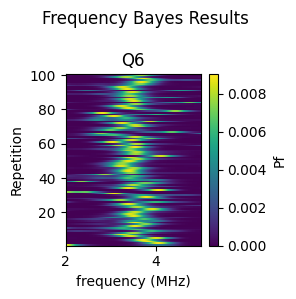

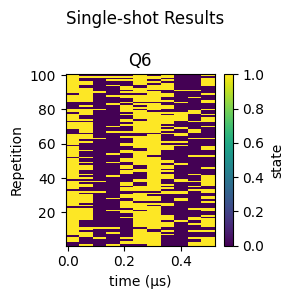

In [ ]:
grid_bayes = QubitGrid(ds, [q.grid_location for q in qubits])
y_data_key = "Pf"

for ax, qubit in grid_iter(grid_bayes):
    qubit_name = qubit["qubit"]
    da = ds_Pf[y_data_key].sel(qubit=qubit_name)
    X, Y = np.meshgrid(da.vf.values, da.repetition.values)
    pcm = ax.pcolormesh(X, Y, da.values, vmin=0)
    ax.set_xlabel("frequency (MHz)")
    ax.set_ylabel("Repetition")
    ax.set_title(qubit_name)
    grid_bayes.fig.colorbar(pcm, ax=ax, label=y_data_key)
    ax.grid(False)

grid_bayes.fig.suptitle("Frequency Bayes Results")
plt.tight_layout()

# Create qubit grid
grid_shot = QubitGrid(ds, [q.grid_location for q in qubits])
y_data_key = "state"
# Loop over grid axes and qubits
for ax, qubit in grid_iter(grid_shot):
    qubit_name = qubit["qubit"]
    t_vals = ds_single.t.values
    y_vals = ds_single[y_data_key].sel(qubit=qubit_name).values

    # Plot data with pcolormesh
    X, Y = np.meshgrid(t_vals*1e-3, np.arange(1, n_reps + 1))
    pcm = ax.pcolormesh(X, Y, y_vals)
    ax.set_xlabel("time (µs)")
    ax.set_ylabel("Repetition")
    ax.set_title(qubit_name)
    grid_shot.fig.colorbar(pcm, ax=ax, label=f"{y_data_key}")
    ax.grid(False)

grid_shot.fig.suptitle("Single-shot Results")
plt.tight_layout()

# Save results

node.results = {
    "ds": ds,
    "figure": grid_bayes.fig,
    "figure_shot": grid_shot.fig,
}
node.machine = machine
node.save()


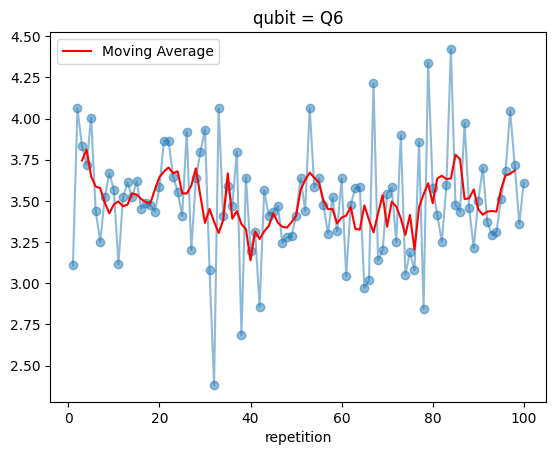

In [ ]:
# Perform vector multiplication to collapse the 'vf' dimension
# Normalize ds.Pf along the 'vf' dimension

collapsed_result = (ds.Pf * ds.vf).sum(dim='vf')
positive_collapsed_result = collapsed_result.where(collapsed_result > 0.1, drop=True)
# positive_collapsed_result = collapsed_result
positive_collapsed_result.plot(marker='o', linestyle='-', alpha=0.5)
window_size = 5  # Define the window size for the moving average
moving_average = positive_collapsed_result.rolling(dim={'repetition': window_size}, center=True).mean()
moving_average.plot(linestyle='-', color='red', label='Moving Average')
plt.legend()


C:\Users\tomdv\AppData\Local\Temp\ipykernel_6452\965817395.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\tomdv\AppData\Local\Temp\ipykernel_6452\965817395.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


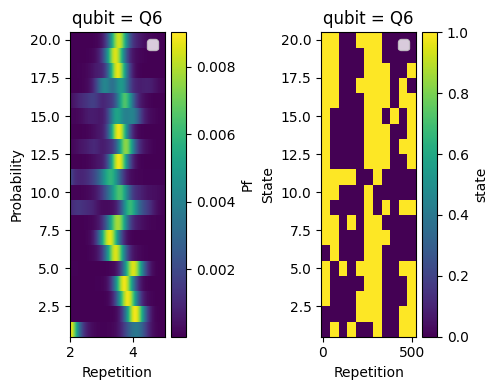

In [ ]:
slice_idx = [0, 20]
fig, axs = plt.subplots(1, 2, figsize=(5, 4))

# Plot Pf
ds.Pf.sel(repetition = slice(slice_idx[0], slice_idx[1])).plot(ax=axs[0])
axs[0].set_xlabel('Repetition')
axs[0].set_ylabel('Probability')
axs[0].legend()

# Plot state
ds.state.sel(repetition = slice(slice_idx[0], slice_idx[1])).plot(ax=axs[1])
axs[1].set_xlabel('Repetition')
axs[1].set_ylabel('State')
axs[1].legend()

plt.tight_layout()
plt.show()
